In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras as keras
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


data = pd.read_csv("data/Stocks/aapl.us.txt")

In [3]:
data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0
...,...,...,...,...,...,...,...
8359,2017-11-06,171.75000,174.36000,171.10000,173.63000,34901241,0
8360,2017-11-07,173.29000,174.51000,173.29000,174.18000,24424877,0
8361,2017-11-08,174.03000,175.61000,173.71000,175.61000,24451166,0
8362,2017-11-09,174.48000,175.46000,172.52000,175.25000,29533086,0


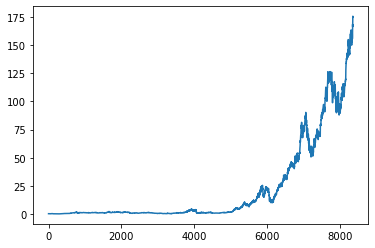

In [4]:
plt.plot(data['Close'])

In [5]:
raw_data = data['Close']
diff_data = data['Close'].diff()

In [6]:
raw_data = raw_data.values.reshape(-1,1)

In [7]:
#split to training (60%), validation(20%) and test data(20%)
train_data,val_data, test_data = diff_data[0:int(len(data)*0.60)],diff_data[int(len(data)*0.60):int(len(data)*0.80)],diff_data[int(len(data)*0.80):len(data)]
raw_test = raw_data[int(len(data)*0.80)-1:len(data)]

In [8]:
training_set = train_data.values.reshape(-1,1)
val_set = val_data.values.reshape(-1,1)

In [9]:
training_set

array([[     nan],
       [-0.00254],
       [ 0.00768],
       ...,
       [-0.0088 ],
       [ 0.0229 ],
       [-0.0191 ]])

In [10]:
#normalise training and validation dataset for training
scaler = MinMaxScaler(feature_range = (0,1))
scalar = scaler.fit(training_set)
scaled_training_set = scaler.transform(training_set)
scaled_val_set = scaler.transform(val_set)

In [11]:
scaled_val_set

array([[0.75833004],
       [0.77132447],
       [0.79375741],
       ...,
       [0.55669696],
       [1.2652443 ],
       [0.88682558]])

In [12]:
#prepare training and validation data
x_train = []
y_train = []
timestep = 60

for i in range(timestep+1,len(training_set)):
    x_train.append(scaled_training_set[i-timestep:i,0])
    y_train.append(scaled_training_set[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(timestep,len(val_set)):
    x_val.append(scaled_val_set[i-timestep:i,0])
    y_val.append(scaled_val_set[i,0])
    
x_val = np.array(x_val)
y_val = np.array(y_val)

#reshape data for lstm training
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)

In [13]:
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)

(4957, 60, 1) (4957,)
(1613, 60, 1) (1613,)


In [70]:
def LSTM_model():
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 35, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 35))
    model.add(keras.layers.Dense(units = 35))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val), verbose = 0)
    return model,history


In [71]:
model,history = LSTM_model()

0.0006436354015022516
0.0340835340321064


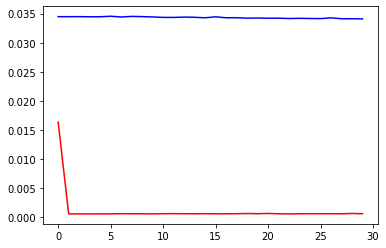

In [73]:
plt.plot(history.history['loss'],color = 'red', label = 'loss')
plt.plot(history.history['val_loss'],color = 'blue', label = 'val loss')
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

In [74]:
#normalising test data for prediction
data_test = pd.concat((val_data, test_data), axis = 0,ignore_index = True)
inputs = data_test[(len(data_test) - len(test_data) - timestep):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

#prepare test data
x_test = []
y_test = []

for i in range(timestep,len(test_data) + timestep):
    x_test.append(inputs[i-timestep:i,0])
    y_test.append(inputs[i,0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [75]:
#prediction for test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_price = []
for i in range(len(y_pred)):
    y_pred_price.append(raw_test[i] + y_pred[i])


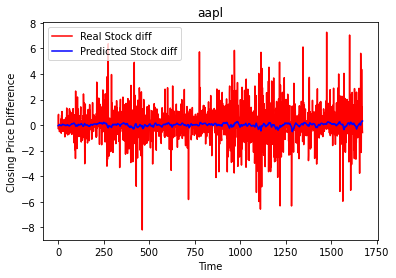

In [76]:
plt.plot(y_test, color = 'red', label = 'Real Stock diff')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock diff')
plt.title('aapl')
plt.xlabel('Time')
plt.ylabel('Closing Price Difference')
plt.legend()
plt.show()

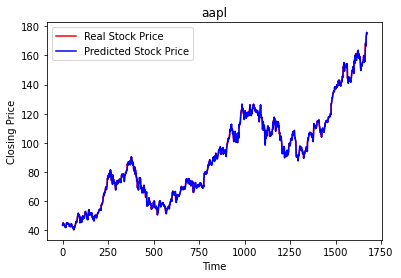

In [77]:
plt.plot(raw_test[1:], color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('aapl')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [78]:
mean_squared_error(y_test,y_pred)

1.961144291709

In [26]:
#investigate the effect of early stopping using val_loss
def LSTM_model_early(tolerant):
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 35, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 35))
    model.add(keras.layers.Dense(units = 35))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=tolerant)
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val),callbacks=[callback], verbose = 0)
    return model,history



In [27]:
def trial():
    full,early,loss1,loss2 = [],[],[],[]
    for i in range(10):
        
        model,history = LSTM_model()
        min_full = history.history['val_loss'][-1]
        min_loss1 = history.history['loss'][-1]
        full.append(min_full)
        loss1.append(min_loss1)
    
        model_early,history_early = LSTM_model_early(5)
        min_early = history_early.history['val_loss'][-1]
        min_loss_e = history_early.history['loss'][-1]
        early.append(min_early)
        loss2.append(min_loss_e)
        
        print(i)
    
    avg_full = mean(full)
    avg_early = mean(early)
    avg_loss1 = mean(loss1)
    avg_loss2 = mean(loss2)
    print('val loss full model',avg_full, 'val loss early stop',avg_early)
    print('loss full model',avg_loss1,'loss early stop',avg_loss2)

In [151]:
trial()

0
1
2
3
4
5
6
7
8
9
val loss full model 0.03425067774951458 val loss early stop 0.034556449949741365
loss full model 0.0006285649142228067 loss early stop 0.0006379820988513529


The difference between training with early stopping and no early stopping for both training loss and validation loss are very small, but early stopping is able to save a significant amount of time for training and grid search.

#grid search done in another notebook

suggested parameter:
timestep = 55
nodes = 45

In [79]:
#prepare training and validation data
x_train = []
y_train = []
timestep = 55

for i in range(timestep+1,len(training_set)):
    x_train.append(scaled_training_set[i-timestep:i,0])
    y_train.append(scaled_training_set[i,0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for i in range(timestep,len(val_set)):
    x_val.append(scaled_val_set[i-timestep:i,0])
    y_val.append(scaled_val_set[i,0])
    
x_val = np.array(x_val)
y_val = np.array(y_val)

#reshape data for lstm training
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],1)

def LSTM_model_GS():
    model = keras.models.Sequential()

    model.add(keras.layers.LSTM(units = 45, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(keras.layers.LSTM(units = 45))
    model.add(keras.layers.Dense(units = 45))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(x_train, y_train, epochs = 40, batch_size = 32, validation_data=(x_val,y_val),callbacks=[callback], verbose = 0)
    return model,history

In [94]:
model,history = LSTM_model_GS()

In [95]:
#normalising test data for prediction
data_test = pd.concat((val_data, test_data), axis = 0,ignore_index = True)
inputs = data_test[(len(data_test) - len(test_data) - timestep):].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

#prepare test data
x_test = []
y_test = []

for i in range(timestep,len(test_data) + timestep):
    x_test.append(inputs[i-timestep:i,0])
    y_test.append(inputs[i,0])
    
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

#prediction for test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_price = []
for i in range(len(y_pred)):
    y_pred_price.append(raw_test[i] + y_pred[i])

In [96]:
raw_test

array([[ 43.696],
       [ 43.436],
       [ 44.179],
       ...,
       [175.61 ],
       [175.25 ],
       [174.67 ]])

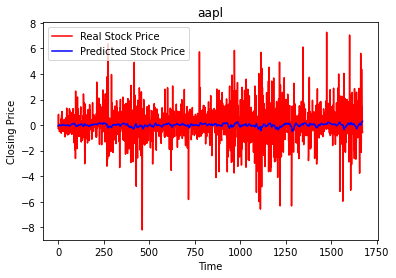

In [97]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('aapl')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [98]:
mean_squared_error(y_test,y_pred)

1.9622285241513382

The mse for the tuned hyperparameters is very close to the mse of the initial model, as the hyperparameter of the initial model is very similar to the tuned hyperparameter, and the initial model ran the full number of epochs, while the final model stops early. 